In [28]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('education_career_success.csv') # make sure dataset is in notebook folder


In [16]:
# Creating new columns that we will use for prediction
df['Risk_Score'] = (10 - df['Career_Satisfaction']) + (10 - df['Work_Life_Balance']) + (df['Years_to_Promotion'] - 1)
df['Instability_Flag'] = ((df['Job_Offers'] < 1) | (df['Starting_Salary'] < 40000) | (df['University_Ranking'] > 700)).astype(int)
df['Change_Tendency'] = ((df['Entrepreneurship'] == 'Yes') | (df['Projects_Completed'] > 5)).astype(int)

In [17]:
# Creating target variables
df['Crisis_Age'] = df['Age'] + np.random.randint(10, 20) - (df['Risk_Score'] // 3)
df['Crisis_Intensity'] = np.clip((df['Risk_Score'] // 2) + df['Instability_Flag']*2, 1, 5)

def assign_crisis_form(row):
    if row['Change_Tendency']:
        return np.random.choice(['Career change', 'Entrepreneurship', 'Extreme hobby'])
    elif row['Field_of_Study'] in ['Business', 'Finance']:
        return np.random.choice(['Extreme purchase', 'Weird hobby'])
    else:
        return np.random.choice(['Breakup', 'Travel adventure', 'Mild career shift'])

df['Crisis_Form'] = df.apply(assign_crisis_form, axis=1)

In [19]:
# Model building
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Pick features and target
X = df[['High_School_GPA', 'University_GPA', 'Internships_Completed', 'Risk_Score', 'Soft_Skills_Score', 'Networking_Score']]
y = df['Crisis_Intensity']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# See how well it does
print("Model Accuracy:", model.score(X_test, y_test))

Model Accuracy: 0.825


In [20]:
# is the model good

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MAE: 0.264
MSE: 0.442
R2 Score: 0.3880963983520135


In [ ]:
# Random Forest Regressor
# explains 97.8% of the variance in crisis intensity!

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Generate a synthetic crisis_intensity score
np.random.seed(42)
crisis_intensity = (
    (4 - df['Work_Life_Balance']) * 0.3 + 
    (10 - df['Career_Satisfaction']) * 0.4 +
    (4.0 - df['University_GPA']) * 0.3 +
    np.random.normal(0, 0.2, len(df))  # add a little randomness
)

# Clip the values between 0 and 10, like a rating scale
crisis_intensity = np.clip(crisis_intensity, 0, 10)

# features and target
X = df[['University_GPA', 'Soft_Skills_Score', 'Networking_Score', 'Career_Satisfaction', 'Work_Life_Balance']]
y = crisis_intensity  # the same synthetic target we generated

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# predictions
y_pred = rf_model.predict(X_test)

# metrics
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MAE: 0.1465382132968947
MSE: 0.03876039805549961
R2 Score: 0.9782897303546795


University_GPA: 0.0238
Soft_Skills_Score: 0.0047
Networking_Score: 0.0049
Career_Satisfaction: 0.6146
Work_Life_Balance: 0.3520


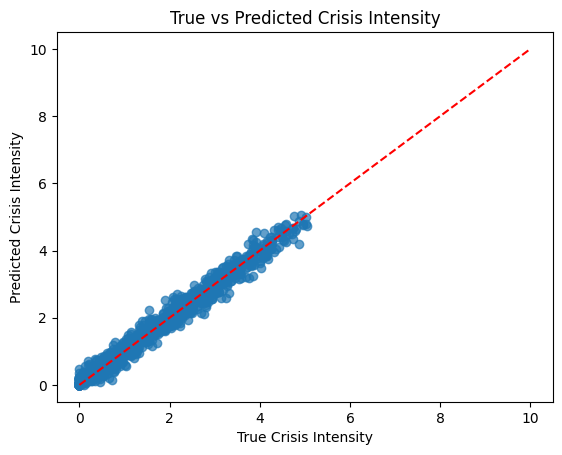

In [29]:
# feature importance
importances = rf_model.feature_importances_
feature_names = X.columns

for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.4f}")

plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('True Crisis Intensity')
plt.ylabel('Predicted Crisis Intensity')
plt.title('True vs Predicted Crisis Intensity')
plt.plot([0,10],[0,10],'r--')
plt.show()

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, min_samples

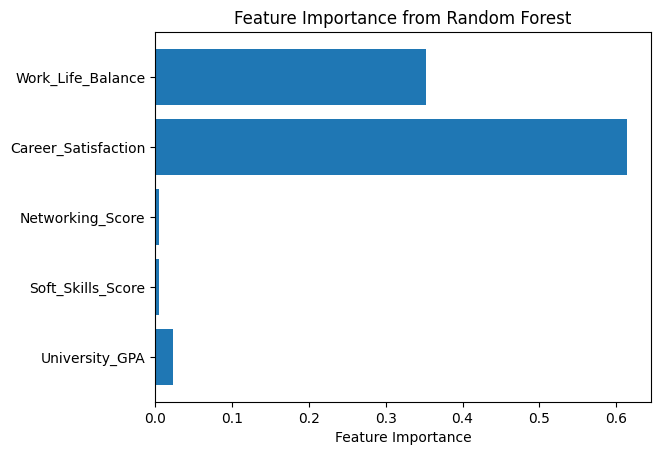

In [30]:
# Fine-tune our Random Forest Regressor by adjusting hyperparameters

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation scores:", scores)

from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

feature_importance = rf_model.feature_importances_
feature_names = X.columns

# Plotting feature importance
plt.barh(feature_names, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.show()


MAE: 0.1435529222336173
MSE: 0.03664924426808963
R2 Score: 0.9794722186748919


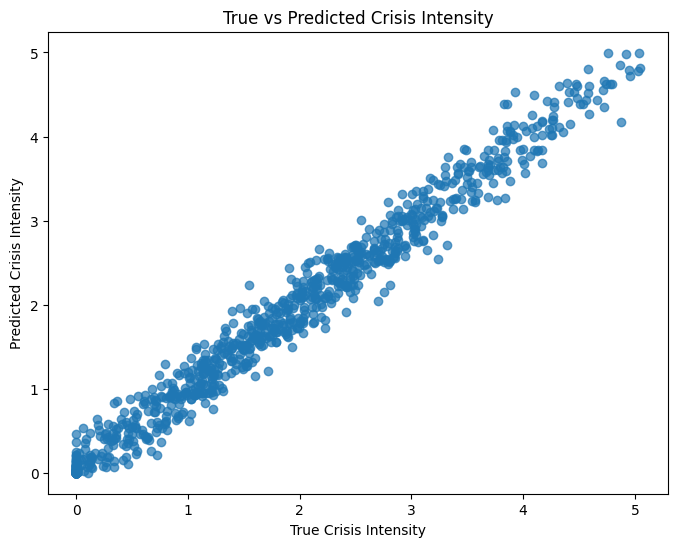

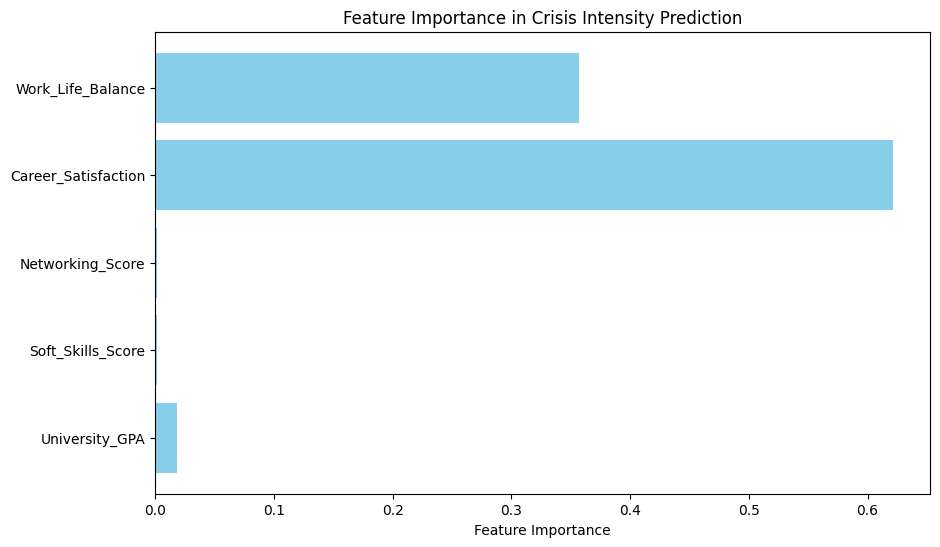

In [31]:
# Training the Model with the Best Hyperparameters

# Re-initialize the RandomForestRegressor with the best parameters
best_rf_model = RandomForestRegressor(
    max_depth=10, 
    min_samples_leaf=4, 
    min_samples_split=10, 
    n_estimators=200,
    random_state=42
)

# Train the model on the full training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_best = best_rf_model.predict(X_test)

# Evaluate the model
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

# Print the evaluation metrics
print("MAE:", mae_best)
print("MSE:", mse_best)
print("R2 Score:", r2_best)

# Plot the true values vs predicted values
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_best, alpha=0.7)
plt.xlabel('True Crisis Intensity')
plt.ylabel('Predicted Crisis Intensity')
plt.title('True vs Predicted Crisis Intensity')
plt.show()

# Get the feature importances
importances = best_rf_model.feature_importances_
feature_names = X.columns

# Plot the feature importances
plt.figure(figsize=(10,6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Crisis Intensity Prediction')
plt.show()